<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">Détectez des faux billets avec R ou Python</h1>
</div>

# Importation des librairies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_percentage_error, classification_report, 
                             confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, 
                             roc_curve, f1_score, silhouette_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from scipy.stats import shapiro, probplot, mode
from sklearn.base import BaseEstimator, ClusterMixin
import joblib


# Étape 1 : Charger les données

In [6]:
# Afficher le datafram
df = pd.read_csv("billets.csv", sep=";")
df.head(5)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [7]:
# répartition des vrais/faux
df["is_genuine"].value_counts()


is_genuine
True     1000
False     500
Name: count, dtype: int64

In [8]:
# inoformations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [9]:
# Lignes en double ?
df.duplicated().sum()

0

In [10]:
# Nombre de valeurs différentes par colonne ?
df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [11]:
# La dispertion globale de nos données :
df.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

In [12]:
# Vérifier les valeurs manquantes
print("Données manquantes :\n", df.isnull().sum())

Données manquantes :
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


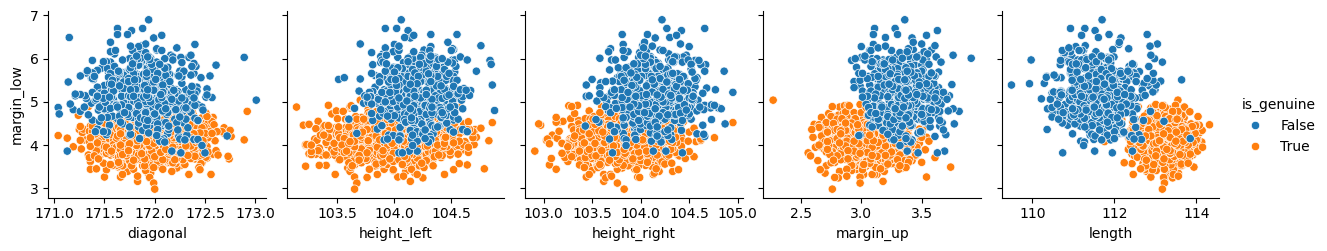

In [13]:
# mise en parralèle de "margin_low" et des autres variables afin d'observer une éventuelle relation
sns.pairplot(df,
             x_vars=["diagonal","height_left", "height_right", "margin_up", "length"], 
             y_vars="margin_low", 
             hue="is_genuine")

### Analyse bivariée

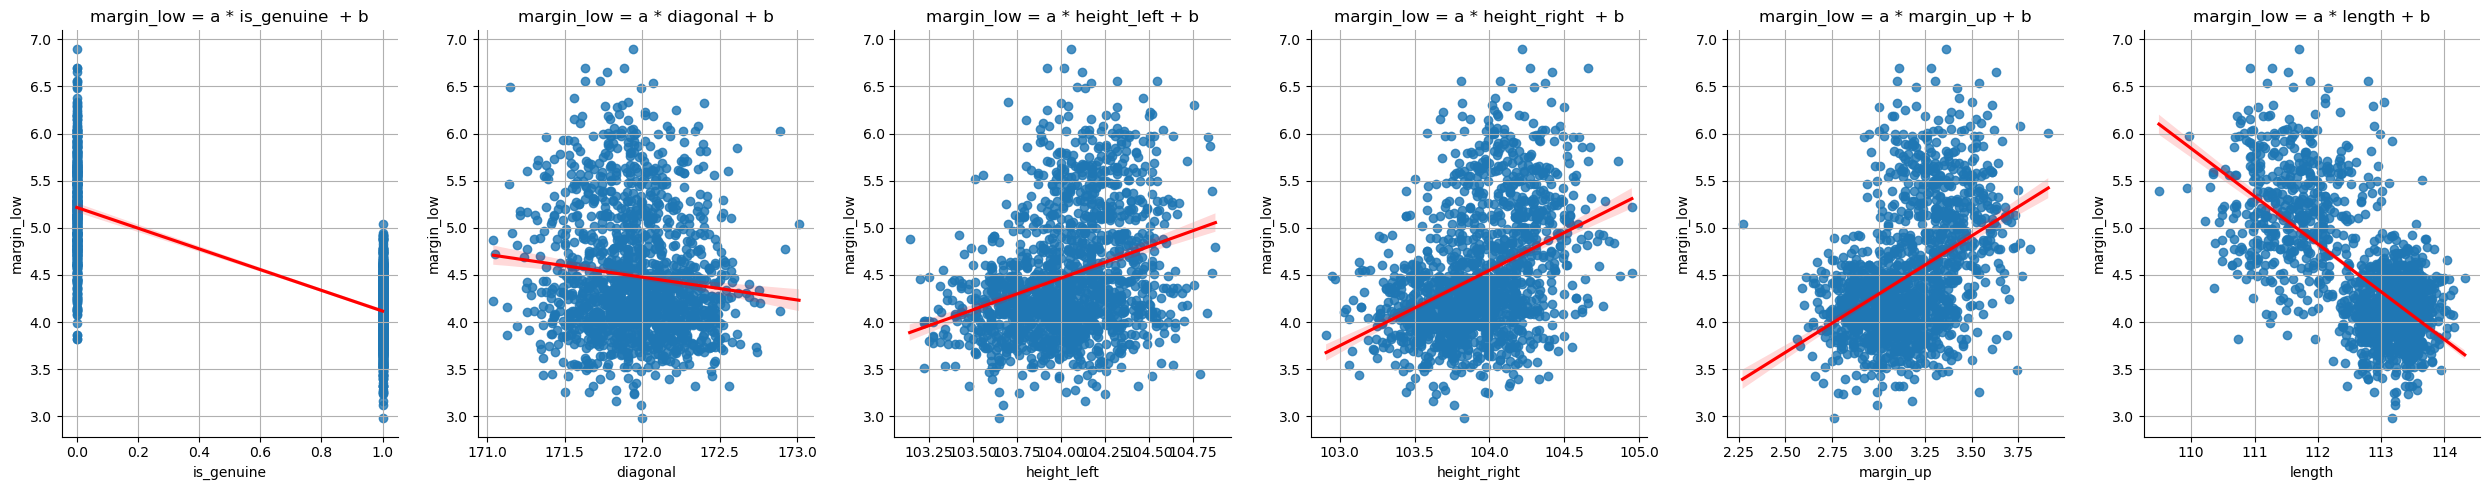

In [15]:
fig, ax = plt.subplots(1,6, figsize = (25,5))

plt.subplot(1,6,1)
sns.regplot(x = df[['is_genuine']],y  =  df.margin_low, line_kws={'color': 'red'})
plt.ylabel('margin_low')
plt.xlabel('is_genuine')
plt.title('margin_low = a * is_genuine  + b')
plt.grid()
sns.despine()

plt.subplot(1,6,2)
sns.regplot(x = df[['diagonal']],y  =  df.margin_low, line_kws={'color': 'red'})
plt.ylabel('margin_low')
plt.xlabel('diagonal')
plt.title('margin_low = a * diagonal + b')
plt.grid()
sns.despine()

plt.subplot(1,6,3)
res = sns.regplot(x = df[['height_left']],y  =  df.margin_low, line_kws={'color': 'red'})
plt.ylabel('margin_low')
plt.xlabel('height_left')
plt.title('margin_low = a * height_left + b')
plt.grid()
sns.despine()



plt.subplot(1,6,4)
sns.regplot(x = df[['height_right']],y  =  df.margin_low, line_kws={'color': 'red'})
plt.ylabel('margin_low')
plt.xlabel('height_right')
plt.title('margin_low = a * height_right  + b')
plt.grid()
sns.despine()

plt.subplot(1,6,5)
sns.regplot(x = df[['margin_up']],y  =  df.margin_low, line_kws={'color': 'red'})
plt.ylabel('margin_low')
plt.xlabel('margin_up')
plt.title('margin_low = a * margin_up + b')
plt.grid()
sns.despine()

plt.subplot(1,6,6)
res = sns.regplot(x = df[['length']],y  =  df.margin_low, line_kws={'color': 'red'})
plt.ylabel('margin_low')
plt.xlabel('length')
plt.title('margin_low = a * length + b')
plt.grid()
sns.despine()

plt.tight_layout()
plt.show()

In [16]:
df.corr()

is_genuine  diagonal  height_left  height_right  margin_low  \
is_genuine      1.000000  0.132756    -0.379833     -0.485092   -0.783032   
diagonal        0.132756  1.000000     0.019472     -0.024492   -0.111534   
height_left    -0.379833  0.019472     1.000000      0.242279    0.302643   
height_right   -0.485092 -0.024492     0.242279      1.000000    0.391085   
margin_low     -0.783032 -0.111534     0.302643      0.391085    1.000000   
margin_up      -0.606262 -0.055649     0.246522      0.307005    0.431606   
length          0.849285  0.097587    -0.320863     -0.401751   -0.666753   

              margin_up    length  
is_genuine    -0.606262  0.849285  
diagonal      -0.055649  0.097587  
height_left    0.246522 -0.320863  
height_right   0.307005 -0.401751  
margin_low     0.431606 -0.666753  
margin_up      1.000000 -0.520575  
length        -0.520575  1.000000

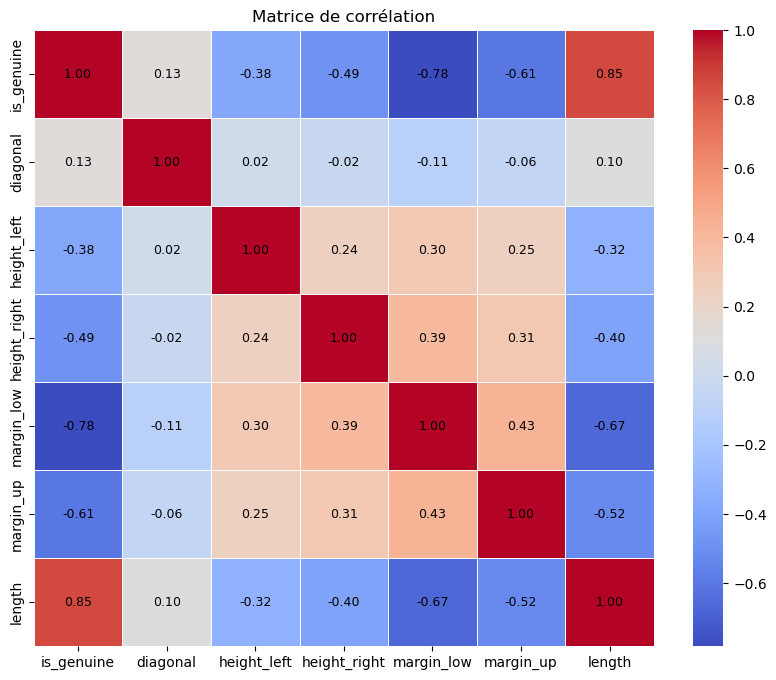

In [17]:
# Visualisation des corrélations

import seaborn as sns
import matplotlib.pyplot as plt

# Augmenter la taille de la figure
plt.figure(figsize=(10, 8))

# Générer la heatmap sans annotations
corr_matrix = df.corr()
ax = sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)

# Ajouter les annotations sans fond blanc
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        text = f"{corr_matrix.iloc[i, j]:.2f}"  # Convertir en string avec 2 décimales
        ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", color="black", fontsize=9)

# Ajouter un titre
plt.title("Matrice de corrélation")
plt.show()



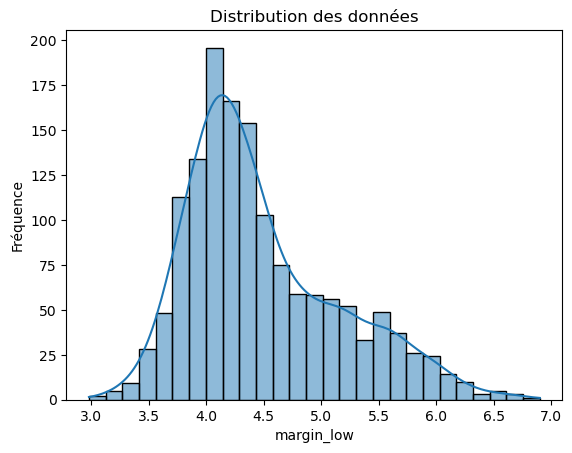

In [18]:
# Sélectionner la colonne à vérifier
column_name = 'margin_low'

# Supprimer les valeurs manquantes pour le test de normalité
data = df[column_name].dropna()

# Tracer la distribution des données
sns.histplot(data, kde=True)
plt.title('Distribution des données')
plt.xlabel(column_name)  
plt.ylabel('Fréquence')
plt.show()

In [19]:
# Test de Shapiro-Wilk pour la normalité
shapiro_test = stats.shapiro(data)
print(f'Test de Shapiro-Wilk : Statistique={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

Test de Shapiro-Wilk : Statistique=0.9377844940452797, p-value=2.82931851362892e-24


###### les données ne suivent pas une distribution normale.

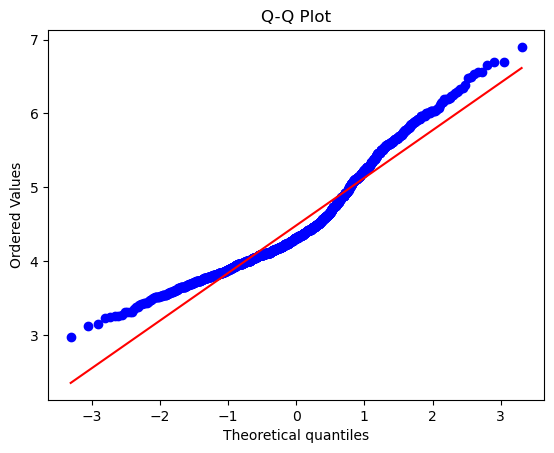

In [21]:
# Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


###### les résidus ne suivent pas une ligne droite, ils ne sont pas normalement distribués.

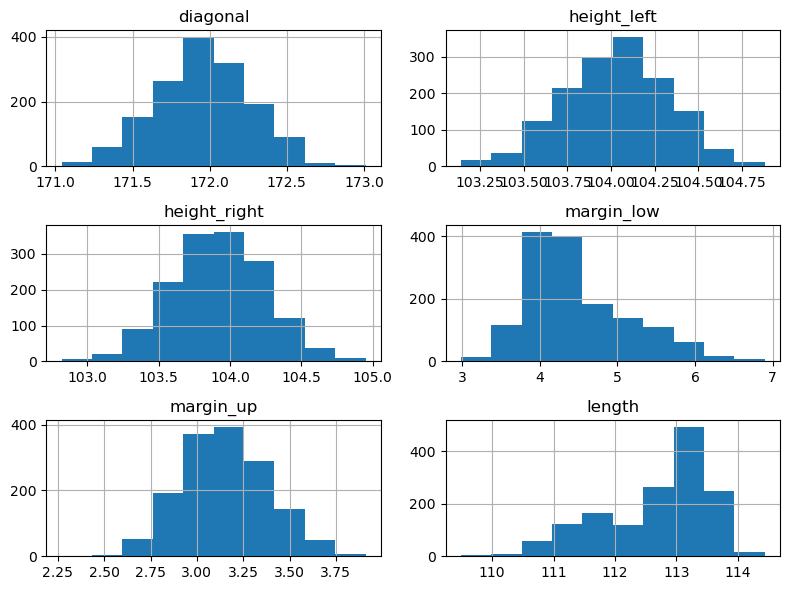

In [23]:
# Analyse des distributions des variables
df.hist(figsize=(8, 6))
plt.tight_layout()
plt.show()

# Relation entre margin_low et les autres variables
#sns.pairplot(df, diag_kind='kde')
#plt.show()

Colonnes avec valeurs manquantes: Index(['margin_low'], dtype='object')
Pourcentage de valeurs manquantes dans 'margin_low': 2.466666666666667 %


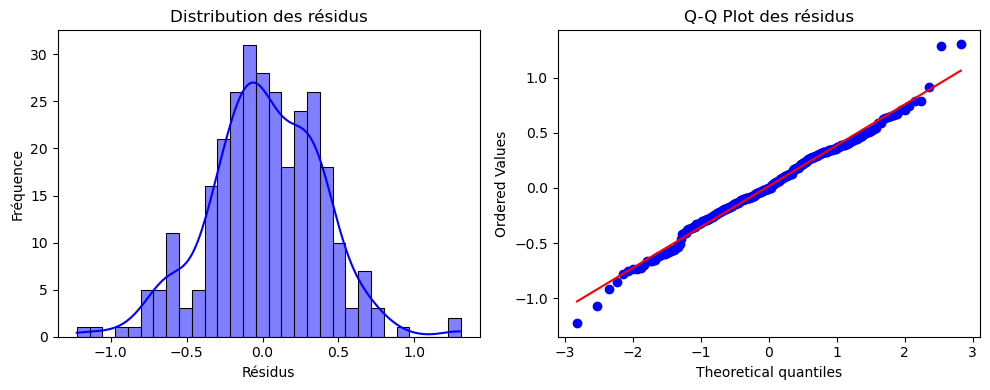

Test de Shapiro-Wilk:
Statistique = 0.9906139775511914, p-valeur = 0.05753873561851918
Les résidus suivent une distribution normale.


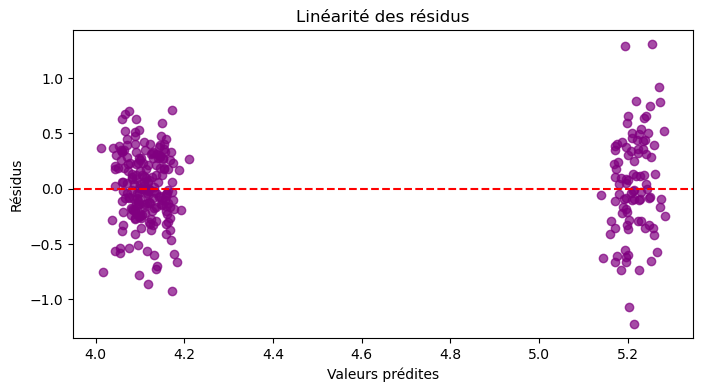

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro, probplot

# Identifier les colonnes avec des valeurs manquantes
missing_columns = df.columns[df.isnull().any()]
print("Colonnes avec valeurs manquantes:", missing_columns)

# Étudier la colonne 'margin_low'
if 'margin_low' in missing_columns:
    print("Pourcentage de valeurs manquantes dans 'margin_low':", df['margin_low'].isnull().mean() * 100, "%")

    # Exclure temporairement les lignes avec des valeurs manquantes pour l'analyse
    temp_data = df.dropna(subset=['margin_low'])

    # Sélectionner les features (exclure 'margin_low')
    features = [col for col in temp_data.columns if col != 'margin_low']

    # Imputation des valeurs manquantes dans les features
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(temp_data[features])
    y = temp_data['margin_low']

    # Diviser les données pour la régression initiale
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Modèle de régression
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    residuals = y_test - predictions

    # Étudier la normalité des résidus
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title("Distribution des résidus")
    plt.xlabel("Résidus")
    plt.ylabel("Fréquence")

    plt.subplot(1, 2, 2)
    probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot des résidus")

    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk pour la normalité
    stat, p_value = shapiro(residuals)
    print("Test de Shapiro-Wilk:")
    print(f"Statistique = {stat}, p-valeur = {p_value}")

    if p_value > 0.05:
        print("Les résidus suivent une distribution normale.")
    else:
        print("Les résidus ne suivent pas une distribution normale.")

     # Étudier la linéarité des résidus
    plt.figure(figsize=(8, 4))
    plt.scatter(predictions, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Linéarité des résidus")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.show()


### Régression linéaire

In [26]:
# Séparer les lignes avec et sans valeurs manquantes dans la colonne contenant les NaN :

# la colonne avec les NaN est 'margin_low'
df_missing = df[df['margin_low'].isna()].copy()

#df_missing = df[df['margin_low'].isna()]
df_not_missing = df.dropna(subset=['margin_low'])

In [27]:
#Définir les variables prédictives et la variable cible :

# Variables prédictives (toutes les colonnes sauf 'margin_low')
X_train = df_not_missing[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
y_train = df_not_missing['margin_low']

In [28]:
# Instancier le Scaler
scaler = MinMaxScaler()

variables = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# et l'appliquer 
data_array = scaler.fit_transform(df[variables])

# transformer le array en dataframe (c'est plus friendly)
df_scaled = pd.DataFrame(data_array,  columns = variables)

# verifier que les min et max des variables sont tous 0 et 1
df_scaled.describe().loc[['min','max']]

diagonal  height_left  height_right  margin_low  margin_up  length
min       0.0          0.0           0.0         0.0        0.0     0.0
max       1.0          1.0           1.0         1.0        1.0     1.0

In [29]:
# Diviser les données en ensembles d'entraînement et de test :

from sklearn.model_selection import train_test_split

X = df_not_missing[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
y = df_not_missing['margin_low']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [30]:
# Entraîner le modèle de régression linéaire :

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Charger les données
df = pd.read_csv('billets.csv', sep=";")

# Créer une copie du DataFrame pour les valeurs manquantes
df_missing = df.copy()

# Sélectionner les caractéristiques pour prédire 'margin_low'
features = ["diagonal", "height_left", "height_right", "margin_up", "length"]
X = df_missing.drop(columns=['margin_low'])
y = df_missing['margin_low']

# Supprimer les lignes avec des valeurs manquantes dans 'margin_low'
df_missing = df_missing.dropna(subset=['margin_low'])

# Entraîner le modèle de régression linéaire
reg = LinearRegression()
reg.fit(df_missing[features], df_missing['margin_low'])

# Prédire les valeurs manquantes et les remplacer dans le DataFrame original
X_missing = df[df['margin_low'].isna()][features]
predicted_values = reg.predict(X_missing)
df.loc[df['margin_low'].isna(), 'margin_low'] = predicted_values

# Renommer le DataFrame en df_final
df_final = df

# Vérifier les valeurs manquantes dans le DataFrame final
missing_values = df_final.isnull().sum()

# Afficher le DataFrame avec les valeurs imputées et les valeurs manquantes
print(df_final.head())
print("\nValeurs manquantes dans le DataFrame final :")
print(missing_values)

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54  

Valeurs manquantes dans le DataFrame final :
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [32]:
# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

# Si les valeurs sont booléennes ou de type non compatible, les convertir en float
y_test = y_test.astype(float)
y_pred_test = y_pred_test.astype(float)

# Calcul des résidus
residuals = y_test - y_pred_test

In [33]:
print(f"RMSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"RMSE: {mean_absolute_percentage_error(y_test, y_pred_test)}")

RMSE: 0.18952518599528345
RMSE: 0.07458892622925645


### Performance du modèle

In [35]:
# Prediction sur le test set
y_pred_test = reg.predict(X_test)

# Scores
print(f"-- Regression margin_low ~ diagonal+height_left+height_right+margin_up+length")
print(f"\tRMSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"\tMAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")

-- Regression margin_low ~ diagonal+height_left+height_right+margin_up+length
	RMSE: 0.18952518599528345
	MAPE: 0.07458892622925645


In [36]:
# les variables prédictives
X = df[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

# la variable cible
y = df.is_genuine

# entrainons le modele
reg = LinearRegression()
reg.fit(X, y)

# le score
print(f"R^2 : {np.round(reg.score(X, y), 6)}")

R^2 : 0.840967


In [37]:

df_final

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

# Étape 3 : Implémenter les algorithmes

# K-means

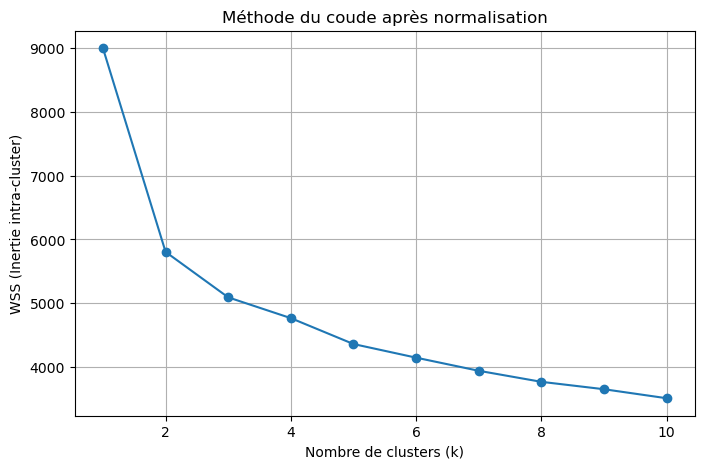

In [40]:
df_kmeans= df

# Vérifier que X contient bien les bonnes variables
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X = df_kmeans[features]  # Sélectionner les bonnes colonnes

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Méthode du coude
wss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_scaled)
    wss.append(kmeans.inertia_)

# Affichage de la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wss, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WSS (Inertie intra-cluster)')
plt.title('Méthode du coude après normalisation')
plt.grid()
plt.show()


In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score
import joblib  # Pour sauvegarder et charger les modèles

# Charger les données
df_kmeans = df  # Remplace par ton fichier

# Définir les variables utilisées pour le clustering (exclure 'is_genuine' car c'est la cible)
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X = df_kmeans[features]  # Variables explicatives
y = df_kmeans["is_genuine"]  # Vraie étiquette (0 = Faux, 1 = Vrai)

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisation des données (important pour K-Means)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Appliquer K-Means sur l'ensemble d'entraînement (choisir k après la méthode du coude)
k = 2  # À ajuster si besoin (2 clusters, vrai/faux)
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans.fit(X_train_scaled)

# Sauvegarder le modèle K-Means et le scaler
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Charger le modèle K-Means et le scaler
kmeans = joblib.load('kmeans_model.pkl')
scaler = joblib.load('scaler.pkl')

# Assigner les clusters aux classes réelles
# On va associer chaque cluster à la classe la plus fréquente (mode) dans ce cluster
mapping = {}
for cluster in np.unique(kmeans.labels_):
    labels_in_cluster = y_train[kmeans.labels_ == cluster]
    mode_label = np.unique(labels_in_cluster, return_counts=True)
    mapping[cluster] = mode_label[0][np.argmax(mode_label[1])]  # La classe la plus fréquente

# Prédire les clusters pour l'ensemble de test
clusters_test = kmeans.predict(X_test_scaled)

# Assigner les classes réelles aux clusters prédits
y_pred = np.array([mapping[cluster] for cluster in clusters_test])

# Évaluer la performance
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy du modèle K-Means : {accuracy:.4f}")
print("Matrice de confusion :\n", cm)

# Score de silhouette (Mesure de la qualité du clustering)
silhouette = silhouette_score(X_train_scaled, kmeans.labels_)
print(f"Silhouette Score (K-Means) : {silhouette:.4f}")


Accuracy du modèle K-Means : 0.9867
Matrice de confusion :
 [[ 98   2]
 [  2 198]]
Silhouette Score (K-Means) : 0.3445


### Visualisation

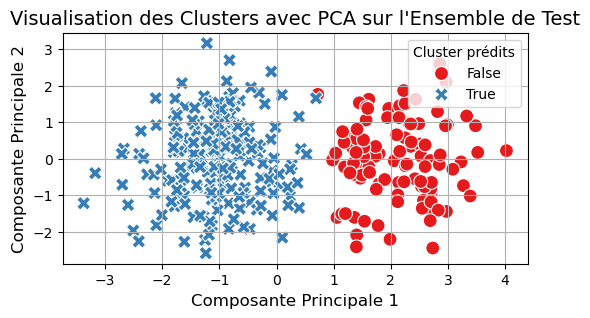

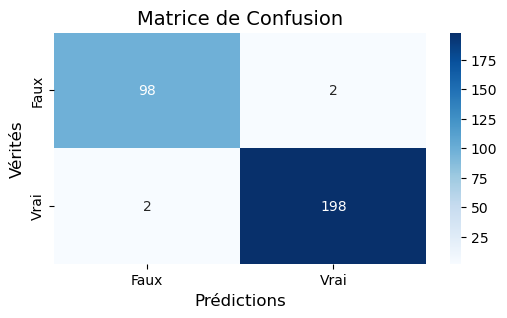

In [43]:
# Visualisation des clusters sur l'ensemble de test avec PCA
pca = PCA(n_components=2)  # Réduction à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(6, 3))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette="Set1", style=y_pred, s=100)

# Ajouter des labels et un titre
plt.title("Visualisation des Clusters avec PCA sur l'Ensemble de Test", fontsize=14)
plt.xlabel("Composante Principale 1", fontsize=12)
plt.ylabel("Composante Principale 2", fontsize=12)
plt.legend(title="Cluster prédits")
plt.grid(True)

# Afficher le graphique
plt.show()

# Visualisation de la matrice de confusion
plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Faux", "Vrai"], yticklabels=["Faux", "Vrai"])
plt.title("Matrice de Confusion", fontsize=14)
plt.xlabel("Prédictions", fontsize=12)
plt.ylabel("Vérités", fontsize=12)
plt.show()

### Appliquer le k-means()

In [45]:
import pandas as pd

# Charger les nouvelles données à tester
df_test = pd.read_csv('nouveau_billet_test0.csv', sep=";")  # Remplace par le fichier de test

# Définir les caractéristiques utilisées
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]

# Vérifier si les colonnes existent dans le DataFrame
missing_features = [feature for feature in features if feature not in df_test.columns]
if missing_features:
    print(f"Les colonnes suivantes sont manquantes dans le fichier de test : {missing_features}")
else:
    X_new = df_test[features]  # Caractéristiques à prédire
    
    # Normaliser les nouvelles données avec le même scaler utilisé lors de l'entraînement
    X_new_scaled = scaler.transform(X_new)  # Assurez-vous que scaler est défini avant !

    # Appliquer le modèle KMeans déjà entraîné pour prédire les clusters
    clusters_test = kmeans.predict(X_new_scaled)  # Assurez-vous que kmeans est défini avant !

    # Mapper les clusters aux classes réelles
    mapping = {0: 'False', 1: 'True'}  # Exemple : 0 = Faux, 1 = Vrai
    y_pred = [mapping[cluster] for cluster in clusters_test]

    # Ajouter les prédictions au DataFrame
    df_test["Predicted Class"] = y_pred

    # Sauvegarder les résultats
    df_test.to_csv('test_avec_predictions.csv', index=False)

    # Afficher les 10 premières lignes du fichier avec les prédictions
df_test.head(10)

  

diagonal  height_left  height_right  margin_low  margin_up  length    id  \
0    171.66       103.92        103.47        4.26       2.83  113.20   A-1   
1    172.16       103.72        103.61        4.30       2.72  113.51   A-2   
2    171.78       103.38        104.22        4.23       3.07  113.77   A-3   
3    171.44       103.96        103.92        3.68       2.89  113.21   A-4   
4    171.56       104.07        103.58        3.55       3.02  112.96   A-5   
5    172.28       103.95        103.91        4.78       3.31  111.40   A-6   
6    171.92       103.86        104.30        4.96       3.13  111.29   A-7   
7    171.59       104.14        104.38        4.97       3.47  111.22   A-8   
8    172.02       104.33        104.33        5.19       3.21  111.99   A-9   
9    172.55       104.25        104.23        5.60       3.13  111.72  A-10   

  Predicted Class  
0            True  
1            True  
2            True  
3            True  
4            True  
5           False  
6           False  
7           False  
8           False  
9           False

# Régression logistique

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib  # Pour sauvegarder le modèle

# Charger le fichier d'entraînement (df)
dfLM = df.copy()  # Copier df à dfLM pour travailler dessus

# Sélectionner les caractéristiques et la cible
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X = dfLM[features]  # Caractéristiques pour l'entraînement
y = dfLM['is_genuine']  # Cible

# Séparer les données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données d'entraînement et de test avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer et entraîner le modèle de régression logistique
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Sauvegarder le modèle et le scaler
joblib.dump(logreg, 'logreg_model.pkl')  # Sauvegarder le modèle
joblib.dump(scaler, 'scaler.pkl')  # Sauvegarder le scaler

# Évaluation du modèle sur l'ensemble de test
y_pred_test = logreg.predict(X_test_scaled)
print("Évaluation du modèle sur l'ensemble de test :")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test))


Évaluation du modèle sur l'ensemble de test :
Accuracy: 0.9900
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



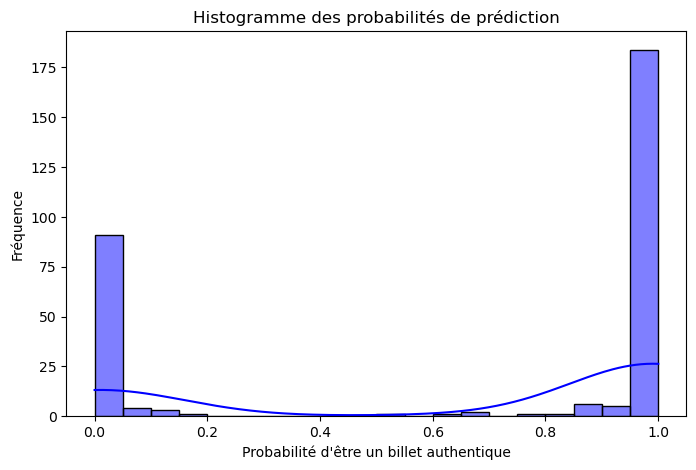

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir les probabilités prédites pour la classe 1 (billet authentique)
y_proba_test = logreg.predict_proba(X_test_scaled)[:, 1]

# Tracer l'histogramme
plt.figure(figsize=(8, 5))
sns.histplot(y_proba_test, bins=20, kde=True, color='blue')
plt.xlabel("Probabilité d'être un billet authentique")
plt.ylabel("Fréquence")
plt.title("Histogramme des probabilités de prédiction")
plt.show()


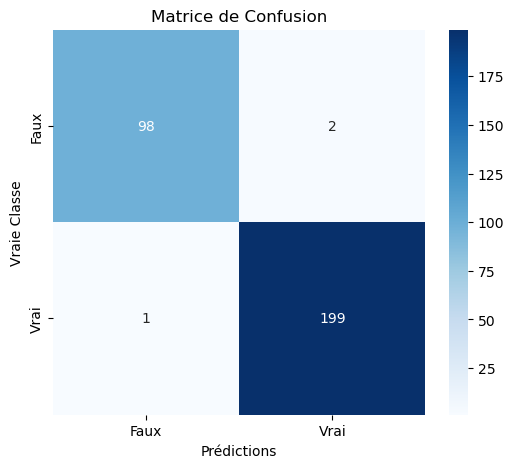

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Faux", "Vrai"], yticklabels=["Faux", "Vrai"])
plt.xlabel("Prédictions")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion")
plt.show()


In [50]:
# Charger le modèle et le scaler sauvegardés
logreg = joblib.load('logreg_model.pkl')  # Charger le modèle sauvegardé
scaler = joblib.load('scaler.pkl')  # Charger le scaler sauvegardé

# Charger un fichier CSV avec les nouvelles données
df_test = pd.read_csv('nouveau_billet_test0.csv', sep=";")  # Remplace par ton fichier de test

# Sélectionner les mêmes caractéristiques utilisées pour l'entraînement
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X_new = df_test[features]  # Caractéristiques à prédire

# Normaliser les données de test avec le même scaler utilisé pour l'entraînement
X_new_scaled = scaler.transform(X_new)

# Appliquer le modèle pour prédire les classes sur les nouvelles données
y_pred_new = logreg.predict(X_new_scaled)

# Ajouter les prédictions dans le DataFrame de test
df_test["Predicted Class"] = y_pred_new

# Sauvegarder les résultats dans un fichier CSV
df_test.to_csv('test_avec_predictions_logreg.csv', index=False)

# Afficher les premières lignes du fichier avec les prédictions
df_test.head(10)


diagonal  height_left  height_right  margin_low  margin_up  length    id  \
0    171.66       103.92        103.47        4.26       2.83  113.20   A-1   
1    172.16       103.72        103.61        4.30       2.72  113.51   A-2   
2    171.78       103.38        104.22        4.23       3.07  113.77   A-3   
3    171.44       103.96        103.92        3.68       2.89  113.21   A-4   
4    171.56       104.07        103.58        3.55       3.02  112.96   A-5   
5    172.28       103.95        103.91        4.78       3.31  111.40   A-6   
6    171.92       103.86        104.30        4.96       3.13  111.29   A-7   
7    171.59       104.14        104.38        4.97       3.47  111.22   A-8   
8    172.02       104.33        104.33        5.19       3.21  111.99   A-9   
9    172.55       104.25        104.23        5.60       3.13  111.72  A-10   

   Predicted Class  
0             True  
1             True  
2             True  
3             True  
4             True  
5            False  
6            False  
7            False  
8            False  
9            False

In [51]:
# Si les labels réels (y_true) sont disponibles dans df_test, les extraire
# Remarque : Assure-toi d'avoir la colonne 'is_fake' dans df_test pour comparer
y_true = df_test['Predicted Class'] if 'Predicted Class' in df_test.columns else None

# Si y_true est disponible, procéder à l'évaluation
if y_true is not None:
    # Prédictions de probabilité pour ROC AUC
    y_probs = logreg.predict_proba(X_new_scaled)[:, 1]

    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(y_true, y_pred_new)
    precision = precision_score(y_true, y_pred_new)
    recall = recall_score(y_true, y_pred_new)
    roc_auc = roc_auc_score(y_true, y_probs)

    # Affichage des résultats de l'évaluation
    print(" Évaluation du modèle :")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")


 Évaluation du modèle :
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC AUC Score: 1.0000


In [52]:
# Charger le modèle et le scaler sauvegardés (si pas déjà fait)
logreg = joblib.load('logreg_model.pkl')  # Charger le modèle
scaler = joblib.load('scaler.pkl')  # Charger le scaler

# Charger un fichier CSV avec de nouvelles données
df_test = pd.read_csv('nouveau_billet_test0.csv', sep=";")  # Remplacer par ton fichier de test

# Prétraitement des nouvelles données : sélection des mêmes caractéristiques utilisées pour l'entraînement
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X_new = df_test[features]

# Normaliser les nouvelles données avec le même scaler utilisé pour l'entraînement
X_new_scaled = scaler.transform(X_new)

# Appliquer le modèle pour prédire les classes (0 ou 1) pour ces nouvelles données
y_pred_new = logreg.predict(X_new_scaled)

# Ajouter les prédictions au DataFrame
df_test["Predicted Class"] = y_pred_new

# Sauvegarder les résultats dans un fichier CSV
df_test.to_csv('test_avec_predictions.csv', index=False)

# Afficher les premières lignes du fichier avec les prédictions
df_test.head(10)


diagonal  height_left  height_right  margin_low  margin_up  length    id  \
0    171.66       103.92        103.47        4.26       2.83  113.20   A-1   
1    172.16       103.72        103.61        4.30       2.72  113.51   A-2   
2    171.78       103.38        104.22        4.23       3.07  113.77   A-3   
3    171.44       103.96        103.92        3.68       2.89  113.21   A-4   
4    171.56       104.07        103.58        3.55       3.02  112.96   A-5   
5    172.28       103.95        103.91        4.78       3.31  111.40   A-6   
6    171.92       103.86        104.30        4.96       3.13  111.29   A-7   
7    171.59       104.14        104.38        4.97       3.47  111.22   A-8   
8    172.02       104.33        104.33        5.19       3.21  111.99   A-9   
9    172.55       104.25        104.23        5.60       3.13  111.72  A-10   

   Predicted Class  
0             True  
1             True  
2             True  
3             True  
4             True  
5            False  
6            False  
7            False  
8            False  
9            False

# K-Nearest Neighbors (KNN)

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib  # Pour sauvegarder le modèle

# Charger le fichier d'entraînement (df)
dfknn = df.copy()  # Copier df à dfknn pour travailler dessus

# Sélectionner les caractéristiques et la cible
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X = dfknn[features]  # Caractéristiques pour l'entraînement
y = dfknn['is_genuine']  # Cible

# Séparer les données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données d'entraînement et de test avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer et entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Choisir un nombre de voisins approprié (ici n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Sauvegarder le modèle et le scaler
joblib.dump(knn, 'knn_model.pkl')  # Sauvegarder le modèle
joblib.dump(scaler, 'scaler_knn.pkl')  # Sauvegarder le scaler

# Évaluation du modèle sur l'ensemble de test
y_pred_test = knn.predict(X_test_scaled)
print("Évaluation du modèle KNN sur l'ensemble de test :")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test))


Évaluation du modèle KNN sur l'ensemble de test :
Accuracy: 0.9833
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       100
        True       0.99      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



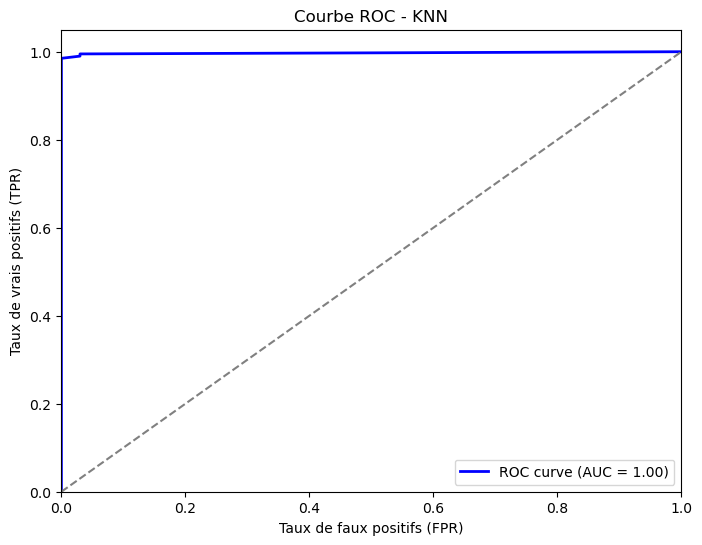

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib

# Charger le modèle et le scaler
knn = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler_knn.pkl')

# Transformer X_test avec le scaler chargé
X_test_scaled = scaler.transform(X_test)

# Prédire les probabilités et tracer la courbe ROC
y_probs = knn.predict_proba(X_test_scaled)[:, 1]

# Prédire les probabilités pour la classe positive
y_probs = knn.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - KNN')
plt.legend(loc='lower right')
plt.show()


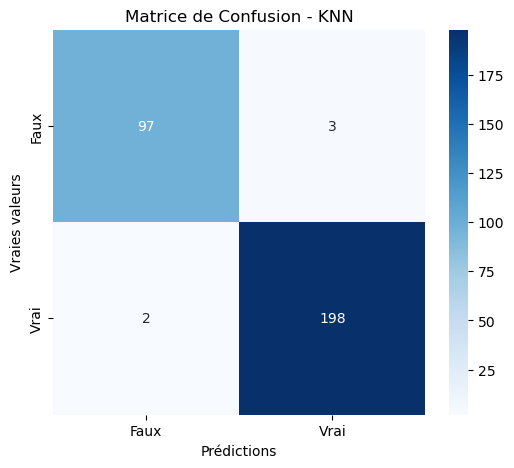

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Afficher la matrice sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion - KNN')
plt.show()


In [57]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import joblib  # Pour charger le modèle et le scaler

# Charger le modèle et le scaler sauvegardés
knn = joblib.load('knn_model.pkl')  # Charger le modèle sauvegardé
scaler = joblib.load('scaler_knn.pkl')  # Charger le scaler sauvegardé

# Charger un fichier CSV avec les nouvelles données
df_test = pd.read_csv('nouveau_billet_test0.csv', sep=";")  # Remplace par ton fichier de test

# Sélectionner les mêmes caractéristiques utilisées pour l'entraînement
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X_new = df_test[features]  # Caractéristiques à prédire

# Normaliser les données de test avec le même scaler utilisé pour l'entraînement
X_new_scaled = scaler.transform(X_new)

# Appliquer le modèle pour prédire les classes sur les nouvelles données
y_pred_new = knn.predict(X_new_scaled)

# Ajouter les prédictions dans le DataFrame de test
df_test["Predicted Class"] = y_pred_new

# Si les labels réels (y_true) sont disponibles dans df_test, les extraire
# Remarque : Assure-toi d'avoir la colonne 'is_fake' dans df_test pour comparer
y_true = df_test['is_fake'] if 'is_fake' in df_test.columns else None

# Si y_true est disponible, procéder à l'évaluation
if y_true is not None:
    # Prédictions de probabilité pour ROC AUC
    y_probs = knn.predict_proba(X_new_scaled)[:, 1]

    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(y_true, y_pred_new)
    precision = precision_score(y_true, y_pred_new)
    recall = recall_score(y_true, y_pred_new)
    roc_auc = roc_auc_score(y_true, y_probs)

    # Affichage des résultats de l'évaluation
    print("Évaluation du modèle KNN :")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

# Sauvegarder les résultats dans un fichier CSV
df_test.to_csv('test_avec_predictions_knn.csv', index=False)

# Afficher les premières lignes du fichier avec les prédictions
df_test.head(10)


diagonal  height_left  height_right  margin_low  margin_up  length    id  \
0    171.66       103.92        103.47        4.26       2.83  113.20   A-1   
1    172.16       103.72        103.61        4.30       2.72  113.51   A-2   
2    171.78       103.38        104.22        4.23       3.07  113.77   A-3   
3    171.44       103.96        103.92        3.68       2.89  113.21   A-4   
4    171.56       104.07        103.58        3.55       3.02  112.96   A-5   
5    172.28       103.95        103.91        4.78       3.31  111.40   A-6   
6    171.92       103.86        104.30        4.96       3.13  111.29   A-7   
7    171.59       104.14        104.38        4.97       3.47  111.22   A-8   
8    172.02       104.33        104.33        5.19       3.21  111.99   A-9   
9    172.55       104.25        104.23        5.60       3.13  111.72  A-10   

   Predicted Class  
0             True  
1             True  
2             True  
3             True  
4             True  
5            False  
6            False  
7            False  
8            False  
9            False

In [58]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import joblib  # Pour charger le modèle et le scaler

# Charger le modèle et le scaler sauvegardés
knn = joblib.load('knn_model.pkl')  # Charger le modèle sauvegardé
scaler = joblib.load('scaler_knn.pkl')  # Charger le scaler sauvegardé

# Charger un fichier CSV avec de nouvelles données
df_test = pd.read_csv('nouveau_billet_test0.csv', sep=";")  # Remplacer par ton fichier de test

# Prétraitement des nouvelles données : sélection des mêmes caractéristiques utilisées pour l'entraînement
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X_new = df_test[features]

# Normaliser les nouvelles données avec le même scaler utilisé pour l'entraînement
X_new_scaled = scaler.transform(X_new)

# Appliquer le modèle pour prédire les classes (0 ou 1) pour ces nouvelles données
y_pred_new = knn.predict(X_new_scaled)

# Ajouter les prédictions au DataFrame
df_test["Predicted Class"] = y_pred_new

# Si les labels réels (y_true) sont disponibles dans df_test, les extraire
y_true = df_test['is_fake'] if 'is_fake' in df_test.columns else None

# Si y_true est disponible, procéder à l'évaluation
if y_true is not None:
    # Prédictions de probabilité pour ROC AUC
    y_probs = knn.predict_proba(X_new_scaled)[:, 1]

    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(y_true, y_pred_new)
    precision = precision_score(y_true, y_pred_new)
    recall = recall_score(y_true, y_pred_new)
    roc_auc = roc_auc_score(y_true, y_probs)

    # Affichage des résultats de l'évaluation
    print(" Évaluation du modèle KNN :")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

# Sauvegarder les résultats dans un fichier CSV
df_test.to_csv('test_avec_predictions_knn.csv', index=False)

# Afficher les premières lignes du fichier avec les prédictions
df_test.head(10)


diagonal  height_left  height_right  margin_low  margin_up  length    id  \
0    171.66       103.92        103.47        4.26       2.83  113.20   A-1   
1    172.16       103.72        103.61        4.30       2.72  113.51   A-2   
2    171.78       103.38        104.22        4.23       3.07  113.77   A-3   
3    171.44       103.96        103.92        3.68       2.89  113.21   A-4   
4    171.56       104.07        103.58        3.55       3.02  112.96   A-5   
5    172.28       103.95        103.91        4.78       3.31  111.40   A-6   
6    171.92       103.86        104.30        4.96       3.13  111.29   A-7   
7    171.59       104.14        104.38        4.97       3.47  111.22   A-8   
8    172.02       104.33        104.33        5.19       3.21  111.99   A-9   
9    172.55       104.25        104.23        5.60       3.13  111.72  A-10   

   Predicted Class  
0             True  
1             True  
2             True  
3             True  
4             True  
5            False  
6            False  
7            False  
8            False  
9            False

# Random Forest

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib  # Pour sauvegarder le modèle

# Charger le fichier d'entraînement (df)
dfRF = df.copy()  # Utilisation de df comme dfRF

# Sélectionner les caractéristiques et la cible
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X = dfRF[features]  # Caractéristiques pour l'entraînement
y = dfRF['is_genuine']  # Cible

# Séparer les données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données d'entraînement et de test avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer et entraîner le modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres dans la forêt
rf.fit(X_train_scaled, y_train)

# Sauvegarder le modèle et le scaler
joblib.dump(rf, 'rf_model.pkl')  # Sauvegarder le modèle
joblib.dump(scaler, 'scaler_rf.pkl')  # Sauvegarder le scaler

# Évaluation du modèle sur l'ensemble de test
y_pred_test = rf.predict(X_test_scaled)
print("Évaluation du modèle Random Forest sur l'ensemble de test :")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test))


Évaluation du modèle Random Forest sur l'ensemble de test :
Accuracy: 0.9900
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



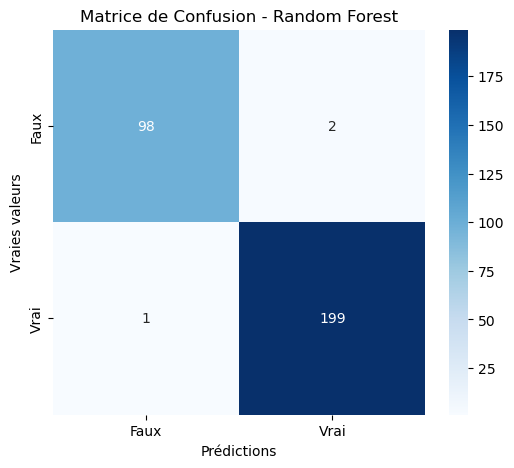

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Afficher la matrice sous forme de heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion - Random Forest')
plt.show()


In [62]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import joblib  # Pour charger le modèle et le scaler

# Charger le modèle et le scaler sauvegardés
rf = joblib.load('rf_model.pkl')  # Charger le modèle sauvegardé
scaler = joblib.load('scaler_rf.pkl')  # Charger le scaler sauvegardé

# Charger un fichier CSV avec les nouvelles données
df_test = pd.read_csv('nouveau_billet_test0.csv',sep=";")  # Remplacer par ton fichier de test

# Sélectionner les mêmes caractéristiques utilisées pour l'entraînement
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X_new = df_test[features]  # Caractéristiques à prédire

# Normaliser les données de test avec le même scaler utilisé pour l'entraînement
X_new_scaled = scaler.transform(X_new)

# Appliquer le modèle pour prédire les classes sur les nouvelles données
y_pred_new = rf.predict(X_new_scaled)

# Ajouter les prédictions dans le DataFrame de test
df_test["Predicted Class"] = y_pred_new

# Si les labels réels (y_true) sont disponibles dans df_test, les extraire
# Remarque : Assure-toi d'avoir la colonne 'is_fake' dans df_test pour comparer
y_true = df_test['is_fake'] if 'is_fake' in df_test.columns else None

# Si y_true est disponible, procéder à l'évaluation
if y_true is not None:
    # Prédictions de probabilité pour ROC AUC
    y_probs = rf.predict_proba(X_new_scaled)[:, 1]

    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(y_true, y_pred_new)
    precision = precision_score(y_true, y_pred_new)
    recall = recall_score(y_true, y_pred_new)
    roc_auc = roc_auc_score(y_true, y_probs)

    # Affichage des résultats de l'évaluation
    print("Évaluation du modèle Random Forest :")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

# Sauvegarder les résultats dans un fichier CSV
df_test.to_csv('test_avec_predictions_rf.csv', index=False)

# Afficher les premières lignes du fichier avec les prédictions
df_test.head(10)


diagonal  height_left  height_right  margin_low  margin_up  length    id  \
0    171.66       103.92        103.47        4.26       2.83  113.20   A-1   
1    172.16       103.72        103.61        4.30       2.72  113.51   A-2   
2    171.78       103.38        104.22        4.23       3.07  113.77   A-3   
3    171.44       103.96        103.92        3.68       2.89  113.21   A-4   
4    171.56       104.07        103.58        3.55       3.02  112.96   A-5   
5    172.28       103.95        103.91        4.78       3.31  111.40   A-6   
6    171.92       103.86        104.30        4.96       3.13  111.29   A-7   
7    171.59       104.14        104.38        4.97       3.47  111.22   A-8   
8    172.02       104.33        104.33        5.19       3.21  111.99   A-9   
9    172.55       104.25        104.23        5.60       3.13  111.72  A-10   

   Predicted Class  
0             True  
1             True  
2             True  
3             True  
4             True  
5            False  
6            False  
7            False  
8            False  
9            False

# Étape 4 : Choix du modèle final

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # Régression Logistique pour la classification
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.cluster import KMeans  # KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le fichier d'entraînement (df)
#df = pd.read_csv('billets.csv')  # Remplacer par le chemin de ton fichier

# Sélectionner les caractéristiques et la cible
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X = df_final[features]  # Caractéristiques pour l'entraînement
y = df_final['is_genuine']  # Cible

# Séparer les données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données d'entraînement et de test avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialiser les modèles
models = {
    'KMeans': KMeans(n_clusters=2, n_init='auto', random_state=42),
    'Régression Logistique': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dictionnaire pour stocker les scores
scores = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'ROC AUC': []}

# Entraîner et évaluer chaque modèle
for model_name, model in models.items():
    if model_name == 'KMeans':
        # KMeans est un algorithme non supervisé, donc pas de y_train
        model.fit(X_train_scaled)
        y_pred = model.predict(X_test_scaled)
        # Convertir les labels en 0 et 1
        y_pred = [0 if label == 0 else 1 for label in y_pred]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # Pour le ROC AUC, obtenir les probabilités pour la classe positive
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_probs = y_pred  # Si le modèle ne supporte pas predict_proba, utiliser y_pred
    roc_auc = roc_auc_score(y_test, y_probs)
    
    # Ajouter les scores au dictionnaire
    scores['Model'].append(model_name)
    scores['Accuracy'].append(accuracy)
    scores['Precision'].append(precision)
    scores['Recall'].append(recall)
    scores['ROC AUC'].append(roc_auc)



# Convertir le dictionnaire en DataFrame
scores_df = pd.DataFrame(scores)

# Afficher la DataFrame des scores
print(scores_df)


                   Model  Accuracy  Precision  Recall  ROC AUC
0                 KMeans  0.986667   0.990000   0.990  0.98500
1  Régression Logistique  0.990000   0.990050   0.995  0.99950
2                    KNN  0.983333   0.985075   0.990  0.99720
3          Random Forest  0.990000   0.990050   0.995  0.99935


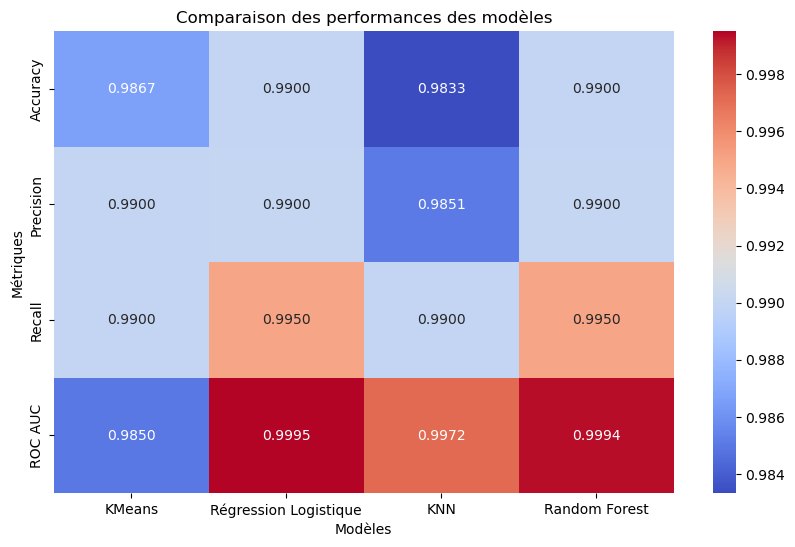

In [65]:
# Créer une heatmap des scores
plt.figure(figsize=(10, 6))
sns.heatmap(scores_df.set_index('Model').T, annot=True, cmap='coolwarm', fmt='.4f', cbar=True)
plt.title('Comparaison des performances des modèles')
plt.ylabel('Métriques')
plt.xlabel('Modèles')
plt.show()




In [66]:
# Convertir X en numpy si c'est un DataFrame
if hasattr(X, "to_numpy"):
    X_np = X.to_numpy()
else:
    X_np = X

# Vérifier si y est déjà un numpy array
if hasattr(y, "to_numpy"):
    y_np = y.to_numpy()
else:
    y_np = y

# Définition du nombre de folds pour la validation croisée
cv_folds = 5  

# Initialisation des modèles supervisés
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Validation croisée pour les modèles supervisés
logreg_scores = cross_val_score(logreg, X_np, y_np, cv=cv_folds, scoring="accuracy")
knn_scores = cross_val_score(knn, X_np, y_np, cv=cv_folds, scoring="accuracy")
rf_scores = cross_val_score(rf, X_np, y_np, cv=cv_folds, scoring="accuracy")

# Validation croisée pour KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
kmeans_scores = []

for train_index, test_index in skf.split(X_np, y_np):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    kmeans.fit(X_train)
    labels = kmeans.predict(X_test)
    
    # Conversion de y_test en entier (évite le problème avec mode())
    y_test = np.array(y_test, dtype=int)

    # Alignement des labels de clustering avec les vraies classes
    labels_corrected = np.zeros_like(labels)
    for i in range(2):  # 2 classes
        mask = (labels == i)
        if np.any(mask):  # Vérifier qu'il y a au moins un élément dans le cluster
            mode_value = mode(y_test[mask]).mode
            if isinstance(mode_value, np.ndarray) and mode_value.size > 0:
                labels_corrected[mask] = mode_value[0]  # Mode sous forme de tableau
            else:
                labels_corrected[mask] = mode_value  # Mode sous forme de scalaire

    kmeans_scores.append(accuracy_score(y_test, labels_corrected))

# Affichage des résultats
print(f"Validation croisée - Logistic Regression: {logreg_scores.mean():.4f} ± {logreg_scores.std():.4f}")
print(f"Validation croisée - KNN: {knn_scores.mean():.4f} ± {knn_scores.std():.4f}")
print(f"Validation croisée - Random Forest: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"Validation croisée - KMeans: {np.mean(kmeans_scores):.4f} ± {np.std(kmeans_scores):.4f}")

Validation croisée - Logistic Regression: 0.9887 ± 0.0045
Validation croisée - KNN: 0.9907 ± 0.0039
Validation croisée - Random Forest: 0.9907 ± 0.0053
Validation croisée - KMeans: 0.9840 ± 0.0068


In [67]:
# Affichage des résultats pour Random Forest
rf_mean = rf_scores.mean()
rf_std = rf_scores.std()

print("Random Forest :")
print(f"\nMoyenne : {rf_mean:.4f}")
print(f"Écart-type : {rf_std:.4f}")
print("Meilleur score en moyenne, ce qui montre que ce modèle capture mieux la relation entre les variables et les classes. ")
print("Cependant, son écart-type est un peu plus élevé, indiquant une légère variabilité dans les performances.")

Random Forest :

Moyenne : 0.9907
Écart-type : 0.0053
Meilleur score en moyenne, ce qui montre que ce modèle capture mieux la relation entre les variables et les classes. 
Cependant, son écart-type est un peu plus élevé, indiquant une légère variabilité dans les performances.


# Étape 5 : Création d'une application fonctionnelle

In [69]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter("ignore", category=UserWarning)

# Charger le modèle Random Forest et le scaler sauvegardés
rf_model = joblib.load('rf_model.pkl')  # Charger le modèle Random Forest
scaler = joblib.load('scaler.pkl')  # Charger le scaler utilisé lors de l'entraînement

# Charger les nouvelles données à tester
df_test0 = pd.read_csv('billets_production.csv', sep=",")  # Remplace par le fichier de test

# Vérifier la présence de la colonne 'id' et la conserver pour la sortie
if "id" not in df_test0.columns:
    raise ValueError("La colonne 'id' est absente du fichier billets_production.csv")

# Prétraitement : Sélectionner les mêmes caractéristiques utilisées lors de l'entraînement
features = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
X_new = df_test0[features]  # Caractéristiques à prédire

# Normaliser les nouvelles données avec le même scaler utilisé pour l'entraînement
X_new_scaled = scaler.transform(X_new)  # Appliquer la même transformation

# Appliquer le modèle Random Forest pour prédire les classes et les probabilités
y_new_pred = rf_model.predict(X_new_scaled)  # Prédictions des classes
y_new_proba = rf_model.predict_proba(X_new_scaled)[:, 1]  # Probabilité d'être un vrai billet (classe 1)

# Ajouter les prédictions et probabilités dans le DataFrame
df_test0["Predicted Class"] = y_new_pred
df_test0["Proba_Vrai"] = y_new_proba  # Ajout des probabilités

# Sauvegarder les résultats dans un fichier CSV
df_test0.to_csv('test_avec_predictions_rf.csv', index=False)

# Afficher les premières lignes du fichier avec les prédictions et probabilités
df_test0.head(10)


diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   Predicted Class  Proba_Vrai  
0            False        0.00  
1            False        0.00  
2            False        0.00  
3             True        0.98  
4             True        1.00